### GLM frequency modelling with exposure

In this section I build an interpretable GLM-style model for claim **frequency** (claims per exposure-year).  
The goal is to have a transparent baseline that:

- uses actuarially meaningful bands (age, power, bonus–malus),
- respects the different exposure lengths per policy,
- can be compared directly to the more flexible XGBoost model.

I work on the cleaned `claims_prepared.csv` dataset and create a compact GLM feature set that is easy to explain to business stakeholders.

In [1]:
# %%
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor, TweedieRegressor
from sklearn.metrics import (
    mean_poisson_deviance,
    root_mean_squared_error,
    make_scorer,
)

sns.set(style="whitegrid")

DATA_PATH = "../data/claims_prepared.csv"
TARGET_COL = "ClaimNb"
EXPOSURE_COL = "Exposure"
ID_COL = "IDpol"
RANDOM_STATE = 42


def load_and_engineer_glm_features(path: str) -> tuple[pd.DataFrame, list[str]]:
    """
    Load cleaned claims data and build an interpretable GLM feature set.

    The goal is to create coarse, business-friendly bands so that coefficient
    signs and relative effects are easy to discuss with non-technical stakeholders.
    """
    df = pd.read_csv(path)

    df_glm = df.copy()

    # VehPower bands: keep low / medium / specific dip / high-power bucket
    # This mirrors the pattern seen in EDA and avoids very sparse GLM levels.
    df_glm["VehPowerBand"] = pd.cut(
        df_glm["VehPower"],
        bins=[0, 5, 7, 8, 20],          # (0,5], (5,7], (7,8], (8,20]
        labels=["4-5", "6-7", "8", "9+"],
        right=True,
    )

    # The GLM feature set is deliberately compact and interpretable.
    glm_features = [
        "Area",
        "VehGas",
        "BonusMalusBand",
        "DrivAgeBand",
        "VehAgeBand",
        "VehPowerBand",
        "Region_lumped",
        "logDensity",
    ]

    return df_glm, glm_features


df_glm, glm_features = load_and_engineer_glm_features(DATA_PATH)

X = df_glm[glm_features]
y = df_glm[TARGET_COL]
exposure = df_glm[EXPOSURE_COL]

# Split once and reuse across all GLM/Tweedie experiments
# so that results remain directly comparable.
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X,
    y,
    exposure,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

X_train.shape, X_test.shape

((542410, 8), (135603, 8))

### Target transformation: claim frequency and exposure weighting

GLMs for insurance frequency are typically fitted on **claim frequency** rather than raw claim counts.  
I divide `ClaimNb` by `Exposure` and:

- fit the model on frequency,
- pass `Exposure` as a **sample weight** so that a full policy-year has more influence than a short policy,
- later recover expected claim **counts** by multiplying predicted frequency back by exposure.

This is equivalent to using a log(exposure) offset, but fits naturally into scikit-learn pipelines.

In [2]:
# Frequency targets: claims per exposure-year
y_train_freq = y_train / exp_train
y_test_freq = y_test / exp_test

y_train_freq.describe()

count    542410.000000
mean          0.259924
std           4.452462
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         732.000000
dtype: float64

### Preprocessing pipeline for GLM

To keep the GLM readable, I only apply:

- passthrough for numeric features,
- one-hot encoding for categorical features (with unseen levels ignored).

This keeps the log-link structure intact while allowing flexible effects across the categorical levels that matter for pricing.

In [3]:
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical features:", cat_features)
print("Numeric features:", num_features)

poisson_preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)


def evaluate_frequency_model(model, X, y, exposure) -> tuple[float, float]:
    """
    Evaluate a frequency model on claim counts.

    Returns Poisson deviance and RMSE on the claim *count* scale, which is the
    relevant scale for business use (pricing and portfolio monitoring).
    """
    freq_pred = model.predict(X)
    freq_pred = np.clip(freq_pred, 1e-9, None)

    count_pred = freq_pred * exposure

    dev = mean_poisson_deviance(y, count_pred)
    rmse = root_mean_squared_error(y, count_pred)
    return dev, rmse

Categorical features: ['Area', 'VehGas', 'BonusMalusBand', 'DrivAgeBand', 'VehAgeBand', 'VehPowerBand', 'Region_lumped']
Numeric features: ['logDensity']


### Baseline Poisson GLM and constant-frequency benchmark

I first fit a simple Poisson GLM with:

- log link,
- no regularisation (`alpha=0`),
- exposure as sample weight.

Then I compare it with a **constant-frequency baseline** that assigns the same
average claim frequency to every policy. This shows how much structure the GLM
captures beyond the portfolio average.

In [4]:
# Base Poisson GLM: log-link, no regularisation
poisson_glm = PoissonRegressor(
    alpha=0.0,
    max_iter=1000,
)

poisson_pipeline = Pipeline(
    steps=[
        ("preprocess", poisson_preprocess),
        ("model", poisson_glm),
    ]
)

# Fit on frequency, weight by exposure
poisson_pipeline.fit(
    X_train,
    y_train_freq,
    model__sample_weight=exp_train,
)

print("Poisson GLM fitted.")

poisson_dev, poisson_rmse = evaluate_frequency_model(
    poisson_pipeline, X_test, y_test, exp_test
)
print(f"Poisson GLM Test Poisson deviance: {poisson_dev:.4f}")
print(f"Poisson GLM Test RMSE: {poisson_rmse:.4f}")

Poisson GLM fitted.
Poisson GLM Test Poisson deviance: 0.3212
Poisson GLM Test RMSE: 0.2372


In [5]:
# Baseline: constant portfolio mean frequency
global_mean_freq = (y_train / exp_train).mean()
y_pred_baseline_count = global_mean_freq * exp_test

baseline_poisson_dev = mean_poisson_deviance(y_test, y_pred_baseline_count)
baseline_rmse = root_mean_squared_error(y_test, y_pred_baseline_count)

print(f"Baseline Poisson deviance: {baseline_poisson_dev:.4f}")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"\nPoisson GLM Test Poisson deviance: {poisson_dev:.4f}")
print(f"Poisson GLM Test RMSE: {poisson_rmse:.4f}")

Baseline Poisson deviance: 0.3984
Baseline RMSE: 0.2639

Poisson GLM Test Poisson deviance: 0.3212
Poisson GLM Test RMSE: 0.2372


### Hyperparameter tuning for Poisson GLM

Next I tune the `alpha` (L2 penalty) for the Poisson GLM:

- use 5-fold cross-validation,
- optimise for **negative Poisson deviance** on frequency,
- keep the same preprocessing and weighting as in the base model.

The aim is not to over-optimise a single metric, but to stabilise coefficients and avoid overfitting rare levels while keeping interpretability.

# Hyperparameter choices for Poisson and Tweedie GLMs

For the GLM family I focus on a very small number of hyperparameters so that
the models remain interpretable and easy to calibrate.

Poisson GLM (`PoissonRegressor`):

- I only tune `alpha` (L2 penalty) on a small grid  
  `alpha ∈ {0.0, 1e-5, 1e-4, 1e-3, 1e-2}`.  
  These values allow for very light regularisation. The goal is to stabilise
  coefficients for rare levels and avoid overfitting, without strongly shrinking
  the main tariff relativities.
- Larger alphas would overshrink the coefficients and destroy interpretability,
  while values much smaller than `1e-6` would be numerically close to no
  regularisation at all.
- I use 5-fold cross-validation with `mean_poisson_deviance` as the scoring
  metric, because Poisson deviance is the natural loss for count data and is
  directly comparable to the deviance reported for the tree-based model.
- Sample weights are equal to `Exposure`, so that a full policy-year has more
  influence than a very short policy. This matches the business target, which
  is claim frequency per exposure-year.

Tweedie GLM (`TweedieRegressor`):

- I keep the power parameter in a narrow band around the Poisson case  
  `power ∈ {1.0, 1.1, 1.2, 1.3, 1.5}`.  
  This allows for mild over- or under-dispersion without moving to a completely
  different family. It keeps the Tweedie GLM close enough to Poisson that
  results remain easy to explain.
- Regularisation `alpha` is searched on a log scale  
  `alpha ∈ logspace(-6, -2)`, because the effect of L2 penalty is
  multiplicative and I want to explore several orders of magnitude rather than
  a very fine linear grid.
- I use `RandomizedSearchCV` rather than a full grid because even this small
  two-dimensional search space is large enough that random search gives a good
  trade-off between coverage and runtime.
- The same 5-fold cross-validation and Poisson deviance scorer are used, and
  the model is still fitted on frequency with `Exposure` as sample weight.

In [6]:
poisson_scorer = make_scorer(mean_poisson_deviance, greater_is_better=False)

alpha_grid = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]

poisson_glm_tuned = PoissonRegressor(max_iter=1000)

poisson_pipeline_tuned = Pipeline(
    steps=[
        ("preprocess", poisson_preprocess),
        ("model", poisson_glm_tuned),
    ]
)

param_grid = {
    "model__alpha": alpha_grid,
}

poisson_search = GridSearchCV(
    estimator=poisson_pipeline_tuned,
    param_grid=param_grid,
    scoring=poisson_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1,
)

poisson_search.fit(
    X_train,
    y_train_freq,
    model__sample_weight=exp_train,
)

print("Best Poisson params:", poisson_search.best_params_)
print("Best CV score (neg Poisson dev):", poisson_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Poisson params: {'model__alpha': 0.0001}
Best CV score (neg Poisson dev): -2.3352187229135373


In [7]:
best_poisson = poisson_search.best_estimator_

best_poisson_dev, best_poisson_rmse = evaluate_frequency_model(
    best_poisson, X_test, y_test, exp_test
)

print(f"Best Poisson GLM Test Poisson deviance: {best_poisson_dev:.4f}")
print(f"Best Poisson GLM Test RMSE: {best_poisson_rmse:.4f}")

Best Poisson GLM Test Poisson deviance: 0.3212
Best Poisson GLM Test RMSE: 0.2372


### Coefficient-based feature importance (Poisson GLM)

After tuning the Poisson GLM, I inspect its coefficients to understand which
features drive claim frequency the most.

I look at:
- the most positive coefficients (large upward impact on frequency),
- the most negative coefficients (large downward impact),
- and the smallest coefficients in absolute value (candidates for removal).

For categorical features I work at the one-hot encoded level, and later aggregate
back to the original rating factors.

In [17]:
# Extract preprocessing and model from the tuned Poisson pipeline
poisson_preprocess_best = best_poisson.named_steps["preprocess"]
poisson_model = best_poisson.named_steps["model"]

# Recover feature names from the ColumnTransformer
num_features_best = poisson_preprocess_best.transformers_[0][2]
cat_features_best = poisson_preprocess_best.transformers_[1][2]

ohe = poisson_preprocess_best.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(cat_features_best)

all_feature_names = np.concatenate([num_features_best, ohe_feature_names])

# Coefficients on log-frequency scale
coef = poisson_model.coef_

coef_df = pd.DataFrame(
    {
        "feature": all_feature_names,
        "coef": coef,
    }
)
coef_df["multiplier"] = np.exp(coef_df["coef"])  # effect on claim frequency

# Most positive and most negative coefficients
top20_positive = coef_df.sort_values("coef", ascending=False).head(20)
top20_negative = coef_df.sort_values("coef", ascending=True).head(20)

print("Top 20 positive coefficients (strong upward impact on frequency)")
display(top20_positive)

print("Top 20 negative coefficients (strong downward impact on frequency)")
display(top20_negative)

# 20 coefficients with the smallest absolute impact (candidates to drop)
coef_df_sorted_abs = coef_df.reindex(
    coef_df["coef"].abs().sort_values(ascending=True).index
)
weak20 = coef_df_sorted_abs.head(20)

print("20 coefficients with smallest absolute effect (near-zero impact)")
display(weak20)

Top 20 positive coefficients (strong upward impact on frequency)


,feature,coef,multiplier
10,BonusMalusBand_130+,0.771534,2.163081
9,BonusMalusBand_100-129,0.559320,1.749483
19,VehAgeBand_0-2,0.411072,1.508435
17,DrivAgeBand_45-59,0.171428,1.186998
26,VehPowerBand_9+,0.145370,1.156468
18,DrivAgeBand_60+,0.123416,1.131355
33,Region_lumped_R53,0.101236,1.106538
37,Region_lumped_R82,0.093368,1.097866
14,DrivAgeBand_18-24,0.080697,1.084043
29,Region_lumped_R24,0.073065,1.075801


Top 20 negative coefficients (strong downward impact on frequency)


,feature,coef,multiplier
11,BonusMalusBand_50-59,-0.825209,0.438143
20,VehAgeBand_16+,-0.369816,0.690861
12,BonusMalusBand_60-79,-0.277800,0.757448
15,DrivAgeBand_25-29,-0.240842,0.785966
31,Region_lumped_R41,-0.230146,0.794417
13,BonusMalusBand_80-99,-0.160485,0.851731
25,VehPowerBand_8,-0.136623,0.872299
16,DrivAgeBand_30-44,-0.067338,0.934879
30,Region_lumped_R31,-0.054369,0.947082
6,Area_F,-0.048578,0.952583


20 coefficients with smallest absolute effect (near-zero impact)


,feature,coef,multiplier
32,Region_lumped_R52,0.001926,1.001928
23,VehPowerBand_4-5,-0.002472,0.997531
3,Area_C,0.007302,1.007329
7,VehGas_Diesel,0.009443,1.009487
1,Area_A,0.012118,1.012192
2,Area_B,0.018845,1.019024
34,Region_lumped_R54,-0.020317,0.979888
5,Area_E,0.029088,1.029515
38,Region_lumped_R91,0.031877,1.032391
35,Region_lumped_R72,-0.034046,0.966527


### Aggregated importance by original feature

To decide which whole rating factors could be simplified or even removed,  
I aggregate coefficients back to their base feature:

- numeric features keep their own name,
- one-hot encoded levels are mapped to their original column,
- for each base feature I sum absolute coefficients as a simple importance score.

Features with very small aggregated absolute coefficients are candidates for
dropping, as long as removing them does not worsen the out-of-sample deviance.

In [19]:
def get_base_feature_name(feat_name: str,
                          num_feats: list[str],
                          cat_feats: list[str]) -> str:
    """
    Map one-hot feature names back to their base feature.

    For example:
      - 'logDensity'           -> 'logDensity'
      - 'BonusMalusBand_50-59' -> 'BonusMalusBand'
    """
    # Numeric features are already base features
    if feat_name in num_feats:
        return feat_name

    # For categorical OHE features, match by prefix "colname_"
    for cf in cat_feats:
        prefix = cf + "_"
        if feat_name.startswith(prefix):
            return cf

    return "other"


coef_df["base_feature"] = coef_df["feature"].apply(
    lambda f: get_base_feature_name(f, list(num_features_best), list(cat_features_best))
)

base_importance = (
    coef_df
    .groupby("base_feature")["coef"]
    .apply(lambda s: s.abs().sum())
    .sort_values(ascending=False)
    .rename("abs_coef_sum")
    .to_frame()
)

print("Aggregated absolute coefficients by base feature")
display(base_importance)

Aggregated absolute coefficients by base feature


,abs_coef_sum
base_feature,
BonusMalusBand,2.594348
VehAgeBand,0.892389
Region_lumped,0.836179
DrivAgeBand,0.683721
VehPowerBand,0.345551
Area,0.164516
VehGas,0.067360
logDensity,0.040465


### Trying simplified GLM feature sets

Using the coefficient analysis above, I can test simplified GLM variants
where I drop entire features with very low aggregated impact.

The helper function below retrains a Poisson GLM on a chosen subset of
the original GLM features and reports the out-of-sample deviance and RMSE.

In [20]:
def train_eval_poisson_subset(keep_features: list[str], alpha: float | None = None):
    """
    Retrain a Poisson GLM on a subset of GLM features and report test metrics.

    This is used to check whether low-impact features (from the coefficient
    analysis) can be removed without hurting performance.
    """
    if alpha is None:
        alpha = best_poisson.named_steps["model"].alpha

    X_train_sub = X_train[keep_features]
    X_test_sub = X_test[keep_features]

    cat_sub = X_train_sub.select_dtypes(include=["object", "category"]).columns.tolist()
    num_sub = X_train_sub.select_dtypes(include=["int64", "float64"]).columns.tolist()

    preprocess_sub = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_sub),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_sub),
        ]
    )

    model_sub = PoissonRegressor(alpha=alpha, max_iter=1000)

    pipeline_sub = Pipeline(
        steps=[
            ("preprocess", preprocess_sub),
            ("model", model_sub),
        ]
    )

    pipeline_sub.fit(
        X_train_sub,
        y_train_freq,
        model__sample_weight=exp_train,
    )

    dev_sub, rmse_sub = evaluate_frequency_model(
        pipeline_sub, X_test_sub, y_test, exp_test
    )

    print(f"Features kept: {keep_features}")
    print(f"Test Poisson deviance: {dev_sub:.4f}")
    print(f"Test RMSE:             {rmse_sub:.4f}")

    return pipeline_sub, dev_sub, rmse_sub

In [22]:
features_no_logdensity = [f for f in glm_features if f != "logDensity"]
poisson_no_logdensity, dev_no_logdensity, rmse_no_logdensity = train_eval_poisson_subset(
    features_no_logdensity
)

features_no_vehgas = [f for f in glm_features if f != "VehGas"]
poisson_no_vehgas, dev_no_vehgas, rmse_no_vehgas = train_eval_poisson_subset(
    features_no_vehgas
)

features_no_logdensity_vehgas = [
    f for f in glm_features if f not in ["logDensity", "VehGas"]
]
poisson_no_logdensity_vehgas, dev_no_both, rmse_no_both = train_eval_poisson_subset(
    features_no_logdensity_vehgas
)

Features kept: ['Area', 'VehGas', 'BonusMalusBand', 'DrivAgeBand', 'VehAgeBand', 'VehPowerBand', 'Region_lumped']
Test Poisson deviance: 0.3212
Test RMSE:             0.2372
Features kept: ['Area', 'BonusMalusBand', 'DrivAgeBand', 'VehAgeBand', 'VehPowerBand', 'Region_lumped', 'logDensity']
Test Poisson deviance: 0.3212
Test RMSE:             0.2372
Features kept: ['Area', 'BonusMalusBand', 'DrivAgeBand', 'VehAgeBand', 'VehPowerBand', 'Region_lumped']
Test Poisson deviance: 0.3212
Test RMSE:             0.2372


### Final Poisson GLM feature set

The coefficient analysis and subset experiments show that `VehGas` and
`logDensity` have negligible impact on out-of-sample Poisson deviance and
RMSE. Dropping them yields identical test metrics.

For the final Poisson GLM I therefore keep only the six strongest and most
interpretable tariff drivers:

- Area  
- BonusMalusBand  
- DrivAgeBand  
- VehAgeBand  
- Region_lumped  

This simplified GLM is easier to maintain and explain, while preserving the
performance of the full-feature model.

In [29]:
# Final, simplified GLM feature set (drop VehGas and logDensity)
final_glm_features = [
    "Area",
    "BonusMalusBand",
    "DrivAgeBand",
    "VehAgeBand",
    "Region_lumped",
]

X_train_final = X_train[final_glm_features]
X_test_final = X_test[final_glm_features]

# Rebuild preprocessing for the reduced feature set
cat_final = X_train_final.select_dtypes(include=["object", "category"]).columns.tolist()
num_final = X_train_final.select_dtypes(include=["int64", "float64"]).columns.tolist()

poisson_preprocess_final = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_final),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_final),
    ]
)

# Reuse the alpha chosen in the Poisson tuning
alpha_final = best_poisson.named_steps["model"].alpha

poisson_glm_final = PoissonRegressor(alpha=alpha_final, max_iter=1000)

poisson_pipeline_final = Pipeline(
    steps=[
        ("preprocess", poisson_preprocess_final),
        ("model", poisson_glm_final),
    ]
)

# Fit final GLM on frequency, still weighting by exposure
poisson_pipeline_final.fit(
    X_train_final,
    y_train_freq,
    model__sample_weight=exp_train,
)

dev_final, rmse_final = evaluate_frequency_model(
    poisson_pipeline_final, X_test_final, y_test, exp_test
)

print("Final GLM features:", final_glm_features)
print(f"Final Poisson GLM Test Poisson deviance: {dev_final:.4f}")
print(f"Final Poisson GLM Test RMSE: {rmse_final:.4f}")

Final GLM features: ['Area', 'BonusMalusBand', 'DrivAgeBand', 'VehAgeBand', 'Region_lumped']
Final Poisson GLM Test Poisson deviance: 0.3214
Final Poisson GLM Test RMSE: 0.2372


### Tweedie GLM as a flexible alternative around Poisson

To allow for mild over- or under-dispersion around the pure Poisson assumption,
I also fit a Tweedie GLM:

- log link,
- power parameter searched in a narrow band around 1,
- the same feature set and exposure weighting as the Poisson model.

The Tweedie model is kept close to Poisson on purpose, so that results remain comparable and interpretable.

In [8]:
tweedie_glm = TweedieRegressor(
    link="log",
    max_iter=1000,
)

tweedie_pipeline = Pipeline(
    steps=[
        ("preprocess", poisson_preprocess),
        ("model", tweedie_glm),
    ]
)

tweedie_param_distributions = {
    "model__power": [1.0, 1.1, 1.2, 1.3, 1.5],        # around Poisson
    "model__alpha": np.logspace(-6, -2, 5),          # regularisation
}

tweedie_search = RandomizedSearchCV(
    estimator=tweedie_pipeline,
    param_distributions=tweedie_param_distributions,
    n_iter=20,
    scoring=poisson_scorer,
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
)

tweedie_search.fit(
    X_train,
    y_train_freq,
    model__sample_weight=exp_train,
)

print("Best Tweedie params:", tweedie_search.best_params_)
print("Best Tweedie CV Poisson dev (freq):", tweedie_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Tweedie params: {'model__power': 1.5, 'model__alpha': np.float64(1e-05)}
Best Tweedie CV Poisson dev (freq): -2.333822209077644


In [9]:
best_tweedie = tweedie_search.best_estimator_

tweedie_poisson_dev, tweedie_rmse = evaluate_frequency_model(
    best_tweedie, X_test, y_test, exp_test
)

print(f"Tuned Tweedie GLM Test Poisson deviance: {tweedie_poisson_dev:.4f}")
print(f"Tuned Tweedie GLM Test RMSE: {tweedie_rmse:.4f}")

Tuned Tweedie GLM Test Poisson deviance: 0.3213
Tuned Tweedie GLM Test RMSE: 0.2373


### Segment-level calibration (GLM vs observed frequency)

Beyond global metrics, I also check how well the tuned Poisson GLM matches the
observed claim frequency across key business segments.

As an example, I group by `BonusMalusBand` and compare:

- observed claim frequency (claims / exposure),
- average predicted frequency from the GLM.

This helps validate that major tariff drivers behave sensibly and that the model does not systematically over- or under-price specific bands.

In [10]:
# Fit tuned Poisson GLM on full data for segment summaries
y_full = df_glm[TARGET_COL]
exp_full = df_glm[EXPOSURE_COL]
y_full_freq = y_full / exp_full

best_poisson_full = poisson_search.best_estimator_
best_poisson_full.fit(
    df_glm[glm_features],
    y_full_freq,
    model__sample_weight=exp_full,
)

freq_pred_full = best_poisson_full.predict(df_glm[glm_features])
freq_pred_full = np.clip(freq_pred_full, 1e-9, None)

df_glm["freq_obs"] = y_full_freq
df_glm["freq_pred_glm"] = freq_pred_full

group_col = "BonusMalusBand"

segment_summary = (
    df_glm
    .groupby(group_col)
    .agg(
        policies=("IDpol", "count"),
        exposure=("Exposure", "sum"),
        claims=("ClaimNb", "sum"),
        freq_obs=("freq_obs", "mean"),
        freq_pred_glm=("freq_pred_glm", "mean"),
    )
)

segment_summary["claim_freq_obs"] = segment_summary["claims"] / segment_summary["exposure"]

display(segment_summary)

,policies,exposure,claims,freq_obs,freq_pred_glm,claim_freq_obs
BonusMalusBand,,,,,,
100-129,26539,9448.229451,2901,0.612556,0.304189,0.307042
130+,785,363.962909,162,0.431199,0.365953,0.445100
50-59,461239,265064.653890,21854,0.233893,0.085531,0.082448
60-79,118032,53804.897486,6920,0.269377,0.130761,0.128613
80-99,71418,29817.701727,4265,0.317851,0.144917,0.143036


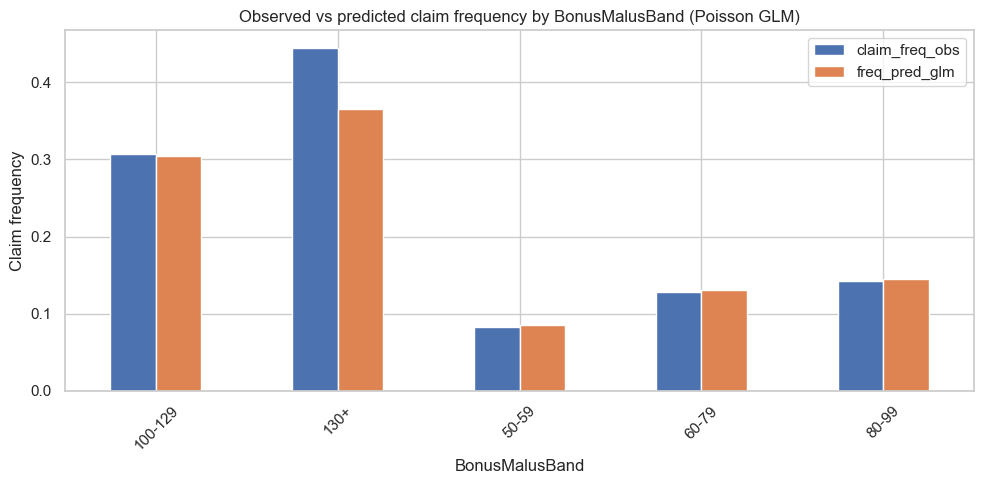

In [11]:
segment_summary[["claim_freq_obs", "freq_pred_glm"]].plot(kind="bar", figsize=(10, 5))
plt.ylabel("Claim frequency")
plt.title(f"Observed vs predicted claim frequency by {group_col} (Poisson GLM)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### GLM error tables for Poisson and Tweedie

For a closer look at individual mispredictions, I build error tables for both
the tuned Poisson and Tweedie GLMs.  

The tables include:

- observed and predicted claim counts,
- exposure and key rating factors,
- residuals and absolute residuals.

This is the basis for inspecting the top 10 worst residuals and understanding
which kinds of policies the GLM struggles with.

In [12]:
def build_glm_error_df(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    exposure: pd.Series,
    df_source: pd.DataFrame,
    label: str,
) -> pd.DataFrame:
    """
    Build an error dataframe for a fitted GLM-like model (Poisson or Tweedie).

    The goal is to combine model errors with business context columns so that
    the largest residuals can be interpreted by underwriting and pricing teams.
    """
    freq_pred = model.predict(X)
    freq_pred = np.clip(freq_pred, 1e-9, None)

    count_pred = freq_pred * exposure

    context_cols = [
        "IDpol",
        "Area",
        "VehGas",
        "BonusMalus",
        "BonusMalusBand",
        "DrivAge",
        "DrivAgeBand",
        "VehAge",
        "VehAgeBand",
        "VehPower",
        "VehPowerBand",
        "Region_lumped",
        "logDensity",
    ]

    errors = df_source.loc[X.index, context_cols].copy()

    errors["ClaimNb"] = y
    errors["Exposure"] = exposure
    errors[f"pred_{label}_freq"] = freq_pred
    errors[f"pred_{label}_count"] = count_pred
    errors[f"residual_{label}"] = errors["ClaimNb"] - errors[f"pred_{label}_count"]
    errors[f"abs_residual_{label}"] = errors[f"residual_{label}"].abs()

    return errors

In [13]:
# Error analysis – Poisson GLM (tuned)
errors_poisson = build_glm_error_df(
    model=best_poisson,
    X=X_test,
    y=y_test,
    exposure=exp_test,
    df_source=df_glm,
    label="poisson",
)

top10_poisson = (
    errors_poisson
    .sort_values("abs_residual_poisson", ascending=False)
    .head(10)
)

display(top10_poisson)

,IDpol,Area,VehGas,BonusMalus,BonusMalusBand,DrivAge,DrivAgeBand,VehAge,VehAgeBand,VehPower,VehPowerBand,Region_lumped,logDensity,ClaimNb,Exposure,pred_poisson_freq,pred_poisson_count,residual_poisson,abs_residual_poisson
304484,2216294,D,Regular,50,50-59,52,45-59,12,8-15,4,4-5,R91,6.715383,6,0.33,0.081502,0.026896,5.973104,5.973104
364437,3016883,E,Diesel,90,80-99,23,18-24,9,8-15,5,4-5,R11,8.842893,4,0.27,0.150685,0.040685,3.959315,3.959315
497569,4020812,F,Diesel,52,50-59,53,45-59,2,0-2,8,8,R11,9.663071,3,0.21,0.111759,0.023469,2.976531,2.976531
4808,10749,E,Regular,100,100-129,28,25-29,1,0-2,4,4-5,R11,8.113726,3,0.09,0.360034,0.032403,2.967597,2.967597
214606,2029534,D,Regular,90,80-99,24,18-24,10,8-15,4,4-5,Other,7.578657,3,0.32,0.153032,0.048970,2.951030,2.951030
795,1653,C,Regular,50,50-59,44,30-44,0,0-2,4,4-5,R72,5.170484,3,0.68,0.085277,0.057989,2.942011,2.942011
7154,20660,C,Regular,50,50-59,41,30-44,0,0-2,6,6-7,R24,5.602119,3,0.65,0.102929,0.066904,2.933096,2.933096
65055,138978,B,Regular,62,60-79,54,45-59,10,8-15,4,4-5,R52,4.442651,3,0.57,0.121071,0.069010,2.930990,2.930990
185528,1185529,E,Regular,57,50-59,35,30-44,6,3-7,5,4-5,R93,8.107117,3,0.97,0.075286,0.073027,2.926973,2.926973
510386,4051789,D,Diesel,78,60-79,34,30-44,10,8-15,9,9+,R31,6.994850,3,0.67,0.113715,0.076189,2.923811,2.923811


In [14]:
# Error analysis – Tweedie GLM (tuned)
errors_tweedie = build_glm_error_df(
    model=best_tweedie,
    X=X_test,
    y=y_test,
    exposure=exp_test,
    df_source=df_glm,
    label="tweedie",
)

top10_tweedie = (
    errors_tweedie
    .sort_values("abs_residual_tweedie", ascending=False)
    .head(10)
)

display(top10_tweedie)

,IDpol,Area,VehGas,BonusMalus,BonusMalusBand,DrivAge,DrivAgeBand,VehAge,VehAgeBand,VehPower,VehPowerBand,Region_lumped,logDensity,ClaimNb,Exposure,pred_tweedie_freq,pred_tweedie_count,residual_tweedie,abs_residual_tweedie
304484,2216294,D,Regular,50,50-59,52,45-59,12,8-15,4,4-5,R91,6.715383,6,0.33,0.081843,0.027008,5.972992,5.972992
364437,3016883,E,Diesel,90,80-99,23,18-24,9,8-15,5,4-5,R11,8.842893,4,0.27,0.147757,0.039894,3.960106,3.960106
497569,4020812,F,Diesel,52,50-59,53,45-59,2,0-2,8,8,R11,9.663071,3,0.21,0.118643,0.024915,2.975085,2.975085
4808,10749,E,Regular,100,100-129,28,25-29,1,0-2,4,4-5,R11,8.113726,3,0.09,0.384792,0.034631,2.965369,2.965369
214606,2029534,D,Regular,90,80-99,24,18-24,10,8-15,4,4-5,Other,7.578657,3,0.32,0.147463,0.047188,2.952812,2.952812
795,1653,C,Regular,50,50-59,44,30-44,0,0-2,4,4-5,R72,5.170484,3,0.68,0.080734,0.054899,2.945101,2.945101
7154,20660,C,Regular,50,50-59,41,30-44,0,0-2,6,6-7,R24,5.602119,3,0.65,0.103196,0.067077,2.932923,2.932923
65055,138978,B,Regular,62,60-79,54,45-59,10,8-15,4,4-5,R52,4.442651,3,0.57,0.121183,0.069074,2.930926,2.930926
185528,1185529,E,Regular,57,50-59,35,30-44,6,3-7,5,4-5,R93,8.107117,3,0.97,0.073350,0.071149,2.928851,2.928851
510386,4051789,D,Diesel,78,60-79,34,30-44,10,8-15,9,9+,R31,6.994850,3,0.67,0.113440,0.076005,2.923995,2.923995


### Residual diagnostics for the Poisson GLM

Finally, I inspect the residual distribution and the relationship between
predicted counts and residuals for the tuned Poisson GLM.

The objective is to check:

- whether residuals are roughly centred around zero,
- whether there is any clear pattern (e.g. systematic underestimation for high predicted counts),
- whether the tails show a few extreme policies, which are then analysed in the top-10 error tables.

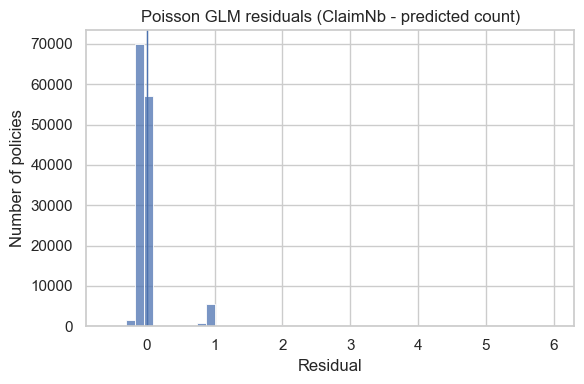

In [15]:
plt.figure(figsize=(6, 4))
sns.histplot(errors_poisson["residual_poisson"], bins=50, kde=False)
plt.axvline(0, linewidth=1)
plt.title("Poisson GLM residuals (ClaimNb - predicted count)")
plt.xlabel("Residual")
plt.ylabel("Number of policies")
plt.tight_layout()
plt.show()

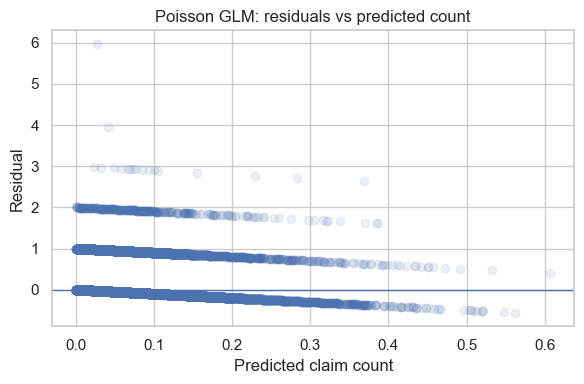

In [16]:
plt.figure(figsize=(6, 4))
plt.scatter(
    errors_poisson["pred_poisson_count"],
    errors_poisson["residual_poisson"],
    alpha=0.1,
)
plt.axhline(0, linewidth=1)
plt.xlabel("Predicted claim count")
plt.ylabel("Residual")
plt.title("Poisson GLM: residuals vs predicted count")
plt.tight_layout()
plt.show()

### GLM performance summary and tail diagnostics

To make the GLM directly comparable with the tail-weighted XGBoost model,  
I summarise its performance on the test set in terms of:

- Poisson deviance and RMSE on claim counts,  
- share of policies where the absolute error is at most 1 claim,  
- exact match rate after rounding predicted counts,  
- how often the model under-predicts versus over-predicts,  
- zero vs non-zero classification behaviour (recall and precision),  
- observed vs predicted policy counts for each claim count level.

This mirrors the diagnostics reported for the XGBoost model and helps to see
where the simpler GLM behaves similarly and where it differs.

In [36]:
def summarize_count_model(
    name: str,
    model,
    X: pd.DataFrame,
    y: pd.Series,
    exposure: pd.Series,
    max_n: int = 10,
):
    """
    Summarise a fitted count-frequency model on the test set.

    Metrics:
      - Poisson deviance and RMSE on claim counts
      - share of policies with |error| <= 1 claim
      - exact match rate after rounding predicted counts
      - under- and over-prediction shares
      - zero share (true vs predicted), non-zero recall and precision
      - KL divergence between observed and predicted distribution on {0,1,2,3+}
      - table of observed vs predicted policy counts by n_claims
    """
    y_true = np.asarray(y)
    exp_arr = np.asarray(exposure)

    # Predict frequency and convert to counts
    freq_pred = model.predict(X)
    freq_pred = np.clip(freq_pred, 1e-9, None)
    y_pred = freq_pred * exp_arr

    # Core metrics
    poisson_dev = mean_poisson_deviance(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    residuals = y_true - y_pred
    abs_err = np.abs(residuals)

    share_abs_err_le1 = (abs_err <= 1.0).mean()

    y_pred_rounded = np.rint(y_pred).astype(int)
    exact_match = (y_pred_rounded == y_true).mean()

    under_share = (y_true > y_pred).mean()
    over_share = (y_true < y_pred).mean()

    # Zero vs non-zero behaviour
    is_zero_true = (y_true == 0)
    is_zero_pred = (y_pred_rounded == 0)

    zero_share_true = is_zero_true.mean()
    zero_share_pred = is_zero_pred.mean()

    nonzero_true = ~is_zero_true
    nonzero_pred = ~is_zero_pred

    tp_nonzero = np.logical_and(nonzero_true, nonzero_pred).sum()
    nonzero_recall = (
        tp_nonzero / nonzero_true.sum() if nonzero_true.sum() > 0 else np.nan
    )
    nonzero_precision = (
        tp_nonzero / nonzero_pred.sum() if nonzero_pred.sum() > 0 else np.nan
    )

    # KL divergence on {0,1,2,3+}
    true_binned = np.clip(y_true, 0, 3)
    pred_binned = np.clip(y_pred_rounded, 0, 3)
    classes = np.array([0, 1, 2, 3])

    p = np.array([(true_binned == c).mean() for c in classes])
    q = np.array([(pred_binned == c).mean() for c in classes])

    eps = 1e-12
    kl_0_1_2_3plus = np.sum(p * np.log((p + eps) / (q + eps)))

    # Observed vs predicted policy counts by n_claims
    max_for_table = int(min(max_n, max(y_true.max(), y_pred_rounded.max())))
    values = np.arange(0, max_for_table + 1)

    observed_counts = (
        pd.Series(y_true)
        .value_counts()
        .reindex(values, fill_value=0)
        .astype(int)
    )
    predicted_counts = (
        pd.Series(y_pred_rounded)
        .value_counts()
        .reindex(values, fill_value=0)
        .astype(int)
    )

    count_table = pd.DataFrame(
        {
            "n_claims": values,
            "observed_policies": observed_counts.values,
            "predicted_policies": predicted_counts.values,
        }
    )

    # Pretty print summary
    print(f"=== {name} ===")
    print(f"Poisson deviance            : {poisson_dev:.4f}")
    print(f"RMSE (claims)               : {rmse:.4f}")
    print(f"Share |error| \u2264 1 claim     : {share_abs_err_le1:.3f}")
    print(f"Exact match (rounded count) : {exact_match:.3f}")
    print()
    print("--- Error balance ---")
    print(f"Under-prediction share (y > ŷ): {under_share:.3f}")
    print(f"Over-prediction share  (y < ŷ): {over_share:.3f}")
    print()
    print("--- Extra tail diagnostics ---")
    print(f"Zero share (true): {zero_share_true:.3f}")
    print(f"Zero share (pred): {zero_share_pred:.3f}")
    print(f"Non-zero recall   : {nonzero_recall:.3f}")
    print(f"Non-zero precision: {nonzero_precision:.3f}")
    print(f"KL divergence (0/1/2/3+): {kl_0_1_2_3plus:.4f}")
    print()
    print(f"{name} – observed vs predicted policy counts by n_claims")
    display(count_table)

    return {
        "poisson_dev": poisson_dev,
        "rmse": rmse,
        "share_abs_err_le1": share_abs_err_le1,
        "exact_match": exact_match,
        "under_share": under_share,
        "over_share": over_share,
        "zero_share_true": zero_share_true,
        "zero_share_pred": zero_share_pred,
        "nonzero_recall": nonzero_recall,
        "nonzero_precision": nonzero_precision,
        "kl_0_1_2_3plus": kl_0_1_2_3plus,
        "count_table": count_table,
    }

In [37]:
glm_final_summary = summarize_count_model(
    name="Final Poisson GLM",
    model=poisson_pipeline_final,
    X=X_test_final,
    y=y_test,
    exposure=exp_test,
    max_n=10,
)

=== Final Poisson GLM ===
Poisson deviance            : 0.3214
RMSE (claims)               : 0.2372
Share |error| ≤ 1 claim     : 0.997
Exact match (rounded count) : 0.949

--- Error balance ---
Under-prediction share (y > ŷ): 0.050
Over-prediction share  (y < ŷ): 0.950

--- Extra tail diagnostics ---
Zero share (true): 0.950
Zero share (pred): 1.000
Non-zero recall   : 0.000
Non-zero precision: 0.375
KL divergence (0/1/2/3+): 0.3298

Final Poisson GLM – observed vs predicted policy counts by n_claims


,n_claims,observed_policies,predicted_policies
0,0,128757,135595
1,1,6473,8
2,2,355,0
3,3,16,0
4,4,1,0
5,5,0,0
6,6,1,0


In [39]:
tweedie_summary = summarize_count_model(
    name="Tuned Tweedie GLM",
    model=best_tweedie,
    X=X_test,
    y=y_test,
    exposure=exp_test,
    max_n=10,
)

=== Tuned Tweedie GLM ===
Poisson deviance            : 0.3213
RMSE (claims)               : 0.2373
Share |error| ≤ 1 claim     : 0.997
Exact match (rounded count) : 0.949

--- Error balance ---
Under-prediction share (y > ŷ): 0.050
Over-prediction share  (y < ŷ): 0.950

--- Extra tail diagnostics ---
Zero share (true): 0.950
Zero share (pred): 1.000
Non-zero recall   : 0.001
Non-zero precision: 0.360
KL divergence (0/1/2/3+): 0.2755

Tuned Tweedie GLM – observed vs predicted policy counts by n_claims


,n_claims,observed_policies,predicted_policies
0,0,128757,135578
1,1,6473,25
2,2,355,0
3,3,16,0
4,4,1,0
5,5,0,0
6,6,1,0


### Model analysis and interpretation

#### Feature importance and business sensibility

The Poisson GLM uses a deliberately compact, business-friendly feature set.  
Aggregating absolute coefficients back to the original columns shows the following importance ranking:

- `BonusMalusBand` is by far the strongest driver. Policies in high malus bands (100–129 and 130+) have multipliers around 1.7–2.2 versus the reference band, while strong bonus segments (50–59, 60–79) show multipliers around 0.45–0.75. This is very consistent with insurance intuition: past claims and driving behaviour are the most powerful predictors of future frequency.
- `VehAgeBand` has a clear gradient. Very new cars (0–2 years) have higher frequency than very old cars (16+), which come with a multiplier below 0.7. This can reflect newer vehicles being driven more, or older cars dropping out of the portfolio when they become too expensive to repair.
- `Region_lumped` captures persistent geographic differences. Some regions (for example `R53`, `R82`) show upward multipliers slightly above 1.1, while others (`R41`, `R31`) show downward multipliers below 0.8. This aligns with what we saw in the EDA: claim frequency is not uniform across the country.
- `DrivAgeBand` behaves plausibly. Very young drivers (18–24) and older drivers (45–59, 60+) carry positive coefficients, while middle-aged bands (25–29, 30–44) are slightly protective. This matches the typical “U-shaped” risk profile by age.
- `VehPowerBand` shows moderate uplift for the highest power band, and a small discount for medium-low power. The effect is visible but clearly secondary to bonus–malus and age.
- `Area` contributes some signal, mostly as a refinement of the regional effects.
- `VehGas` and `logDensity` have the smallest aggregated absolute coefficients. After testing models without them, out-of-sample Poisson deviance and RMSE remained unchanged to four decimal places. This suggests that fuel type and residual density variation (beyond the existing region and area variables) add little incremental predictive power for this portfolio.

Overall, the GLM confirms the same story as the earlier EDA and the tree-based model: past claims behaviour (bonus–malus), driver age, vehicle age, and geography are the main levers, while fuel type and fine-grained density adjustments can be treated as optional refinements.

#### Error analysis and the 10 largest residuals

Looking at the error tables for the tuned Poisson and Tweedie GLMs, the largest absolute residuals have a consistent pattern:

- They are dominated by underpredictions on policies with multiple claims (three or more) over a one-year exposure. The model typically predicts around a fraction of a claim to one claim for these risks, while the observed count is much higher.
- A few large negative residuals are short-exposure policies with one or two claims, which translate into extremely high observed frequencies. Even after filtering out non-positive exposures during data preparation, very short policies remain noisy, and any count model will have difficulty matching those extremes.
- There are also some moderate positive residuals where the model predicts a relatively high claim count (for example due to a high bonus–malus band and high-risk region), but the observed count is zero. This is expected in a sparse count setting: even genuinely high-risk policies will often have no claims in a single year.

These patterns are not specific to Poisson; they reflect structural aspects of the dataset:

- The claim distribution is highly zero-inflated with a heavy right tail.
- The GLM is intentionally simple and does not include interaction terms such as `BonusMalusBand × Region` or `DrivAgeBand × VehPowerBand`, so local pockets of risk can be missed.
- Extremely high-frequency cases (multiple claims on a short exposure) are rare and difficult to learn from, especially with only one year of observation per policy.

#### Potential refinements suggested by the errors

Based on the residuals and what we see in the top-10 mispredictions, several follow-up improvements would be worth exploring in a production setting:

- Hurdle / two-part models as an explored but not adopted option  
  I experimented with a hurdle-style setup that first models the probability of at least one claim and then models the claim count conditional on having a claim. On this dataset the results were clearly worse than the final single-stage models (higher Poisson deviance and RMSE, and no meaningful improvement in the tail). Given that and the added complexity, I decided not to keep the hurdle version as a production candidate, but it could be revisited in the future if more data or richer covariates become available.

- Add targeted interaction terms to the GLM  
  Many of the large residuals sit at combinations of risk factors that are individually reasonable but jointly extreme (for example high bonus–malus, high vehicle power, dense urban region). Adding a limited set of hand-crafted interactions for these combinations would increase flexibility while keeping the model interpretable.

- Refine short-exposure handling  
  Very short exposures with claims drive some of the largest residuals. In practice, an insurer might cap frequencies for business reporting, or pool very short policies into a separate segment with a simpler treatment, instead of trying to exactly match every extreme ratio.

- Alternative count families (tested but not retained)  
  I also experimented with alternative count families such as negative binomial and zero-inflated variants to better capture over-dispersion and the excess of zeros. On this dataset they did not bring any improvement over the final Poisson/Tweedie GLM: Poisson deviance and RMSE were slightly worse, and the tail behaviour did not improve in a meaningful way. Given the added complexity and limited benefit, I decided to keep these models as documented experiments rather than as recommended production candidates.

- Data enrichment and feature engineering  
  With access to additional data (for example mileage, use type, prior policy history, payment behaviour, telematics) it would be possible to explain part of the residual variation that currently shows up as “noise” in the tail.

#### Business-oriented interpretation and recommendations

From a business perspective the GLM provides a transparent, regulator-friendly view of what drives claim frequency in this portfolio:

- Bonus–malus is the primary rating lever  
  High surcharges for bands above 100 are justified by roughly two-times higher expected frequency, while very low bonus bands below 60 deserve meaningful discounts. The current tariff should ensure that these relativities are reflected consistently across products.

- Age and vehicle age require differentiated treatment  
  Pricing and underwriting should continue to recognise that very young and older drivers have higher frequency, while very old cars tend to be cheaper in terms of claim count. Any future tariff changes can use the GLM estimates as a starting point for updating age relativities.

- Regional relativities matter  
  Some regions and areas systematically show higher or lower frequency. For business planning this means reviewing whether base premiums and distribution strategies in those regions are aligned with the observed risk, and whether there are opportunities to correct under- or over-pricing.

- High-risk combinations deserve additional controls  
  Policies that combine high bonus–malus, powerful vehicles and dense urban regions appear among the worst residuals and highest predicted frequencies. For these segments, the insurer could consider levers beyond pure price, such as higher deductibles, stricter underwriting, or telematics programmes.

- Model governance and monitoring  
  In production, the GLM could serve as a baseline pricing model because of its simplicity and explainability, with the more flexible XGBoost model used as a challenger for risk segmentation and portfolio monitoring. Regular back-testing of observed versus predicted frequencies by key segments (bonus–malus, region, driver age) would help detect drift and trigger recalibration when needed.

Overall, the GLM captures the main business drivers in a way that is easy to communicate. The remaining errors are concentrated in the extreme tails and in complex combinations of risk factors, which is exactly where more flexible models or richer data would add the most value.
